# Challenge 2 ANNDL: Segmentation

### Approach

Base: the segmentation exercise from the exercise session of ANNDL
Improvement: First some small changes (as the leraning rate, tried some other loss function, add my_IoU). Then i explored some well-known architectures as U-net (by hand) and other using a library (linked above). Then the transfer learning method gave me the better result (i used imagenet weights, with vgg16 and then xception classifier), but the worst performance above the ather methods.

### Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K

# Check the GPU
'''
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
'''

SEED = 1234
tf.random.set_seed(SEED)  
cwd = os.getcwd()

### Directory structure

- Segmentation_Dataset/
    - training/
        - images/
            - img/
                - img1, img2, …, imgN
        - masks/
            - img/
                - mask1, mask2, ... , maskN
    - test/
        - images/
            - img/
                - img1, img2, …, imgN

### Upload and preprocessing (ImageDataGenerator)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use rescale=1./255 in the mask ImageDataGenerator to obtain binary values {0, 1} as target
apply_data_augmentation = False
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='constant',
                                            cval=0,
                                            validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                             rescale=1./255,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='constant',
                                             cval=0,
                                             validation_split=0.2)
else:
    train_img_data_gen = ImageDataGenerator(validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255,
                                             validation_split=0.2)

test_img_data_gen = ImageDataGenerator()

### Create generators to read images from dataset directory

In [3]:
# Use color_mode='grayscale' in the mask flow_from_directory to obtain single-channel images
# Use class_mode=None because we have no class subfolders in this case
dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')

# Batch size
bs = 8

# img shape
img_h = 256
img_w = 256

num_classes=2

# Training
# Two different generators for images and masks
training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None,
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset='training')  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         color_mode='grayscale',
                                                         batch_size=bs,
                                                         class_mode=None, 
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED,
                                                         subset='training')
train_gen = zip(train_img_gen, train_mask_gen) # combine generators into one which yields image and masks

# Validation
valid_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       batch_size=bs, 
                                                       class_mode=None,
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset='validation')
valid_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         color_mode='grayscale',
                                                         batch_size=bs, 
                                                         class_mode=None,
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED,
                                                         subset='validation')
valid_gen = zip(valid_img_gen, valid_mask_gen)

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_img_gen = test_img_data_gen.flow_from_directory(test_dir,
                                                     target_size=(img_h, img_w),
                                                     batch_size=1, 
                                                     class_mode=None, 
                                                     shuffle=False,
                                                     interpolation='bilinear',
                                                     seed=SEED)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1235 images belonging to 1 classes.


### Create Dataset objects

**Tip**: When using data augmentation on masks we recommend to cast mask tensor to tf.int32. When applying geometric transformations, like rotation or zoom, the output is interpolated so you will end up with values in [0, 1] which are no longer binary. Casting to integer will allow to obtain again binary masks. 

In [5]:
# [None, img_h, img_w, 3] -> (samples number, height, width, channels)
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))

def prepare_target(x_, y_):
    y_ = tf.cast(y_, tf.float32)
    return x_, y_

train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()

# Validation dataset
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
valid_dataset = valid_dataset.map(prepare_target)
valid_dataset = valid_dataset.repeat()

# Test dataset
test_dataset = tf.data.Dataset.from_generator(lambda: test_img_gen,
                                              output_types=(tf.float32),
                                              output_shapes=([None, img_h, img_w, 3]))

test_dataset = test_dataset.repeat()

### Test data generator

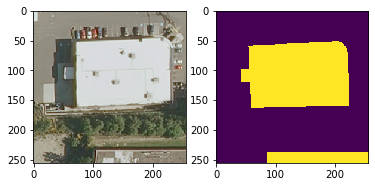

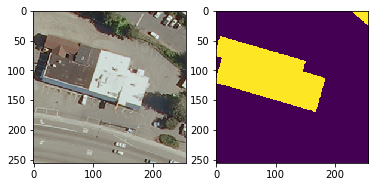

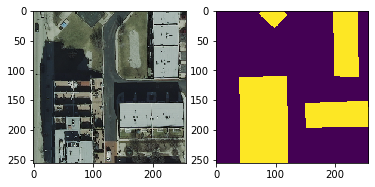

In [7]:
#Just to inspect the data from the dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
iterator = iter(train_dataset)

for _ in range(3):
    fig = plt.figure()
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]   # First element
    augmented_img = augmented_img / 255  # denormalize
    target=target[0]
    a = fig.add_subplot(1, 2, 1)
    
    imgplot = plt.imshow(augmented_img)
    target = target[:,:,0]
    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(target)
    

## Actual CNN 

### Create model

#### Example model (max result = 0,34)

This model is the example model from the exercise class, to try and understand what is done

In [9]:
%%script false 

def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    for i in range(depth): 
        if i == 0:
            input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Decoder
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f // 2,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))

        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    return model

model = create_model(depth=4, 
                     start_f=4, 
                     num_classes=1)

Couldn't find program: 'false'


#### U-Net model (by hand - max result = 0,52)

Model based on the U-net network, with some minor changes

In [11]:
%%script false

inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

Couldn't find program: 'false'


### Transfer Learning (max result = 0,58)

Used a library from https://segmentation-models.readthedocs.io/en/latest/api.html#unet, useful to implement some famous architectures and transfer learning weigth initialization

In [12]:
from segmentation_models import Unet
model = Unet(backbone_name='inceptionv3',
                         input_shape=(256, 256, 3),
                         classes=1,
                         activation='sigmoid',
                         weights=None,
                         encoder_weights='imagenet',
                         encoder_freeze=False,
                         encoder_features='default',
                         decoder_block_type='upsampling',
                         decoder_filters=(256, 128, 64, 32, 16),
                         decoder_use_batchnorm=True)

Segmentation Models: using `tf.keras` framework.
A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of bcbd6486424b2319ff4ef7d526e38f63 so we will re-download the data.
87916544/87910968 [==============================] - 29s 0us/step


### Check the Model

In [13]:
# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Loss and Optimization

Here the major change from class is the lower leraning rate (gives better results) and the jaccard loss function that for our problem is preferred (but slower)

In [14]:
import segmentation_models
# Optimization params

# Loss
loss = segmentation_models.losses.JaccardLoss(class_weights=None, class_indexes=None, per_image=False, smooth=1e-05)
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) 

# learning rate
lr = 5e-4
#mom = 1e-3
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=mom, nesterov=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
def my_IoU(y_true, y_pred):
    # from pobability to predicted class {0, 1}
    #y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax

    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union



# Kaggle validation metrics
"""def calculate_competition_score(y_true, y_pred):
    score = my_IoU(y_true, y_pred)
    
    thresholds = np.arange(0.5, 1.0, 0.05)
    competition_score = 0
    for t in thresholds:
        t = tf.constant(t, dtype=tf.float32)
        if score > t:
            competition_score += 1

    competition_score /= len(thresholds)
    return competition_score"""

metrics = [my_IoU]

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

'def calculate_competition_score(y_true, y_pred):\n    score = my_IoU(y_true, y_pred)\n    \n    thresholds = np.arange(0.5, 1.0, 0.05)\n    competition_score = 0\n    for t in thresholds:\n        t = tf.constant(t, dtype=tf.float32)\n        if score > t:\n            competition_score += 1\n\n    competition_score /= len(thresholds)\n    return competition_score'

### Model Fitting

In [15]:
#%%script false
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "challenge_2/{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Early Stopping
early_stop = True
if early_stop:
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fitting
model.fit(x=train_dataset,
          epochs=100,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen),
          callbacks=[cp_callback, earlystopper])

Train for 765 steps, validate for 192 steps
Epoch 1/100
764/765 [============================>.] - ETA: 0s - loss: 0.4029 - my_IoU: 0.5971
Epoch 00001: saving model to challenge_2/01.ckpt
765/765 [==============================] - 300s 393ms/step - loss: 0.4027 - my_IoU: 0.5973 - val_loss: 0.3662 - val_my_IoU: 0.6338
Epoch 2/100
764/765 [============================>.] - ETA: 0s - loss: 0.3297 - my_IoU: 0.6703
Epoch 00002: saving model to challenge_2/02.ckpt
765/765 [==============================] - 275s 359ms/step - loss: 0.3296 - my_IoU: 0.6704 - val_loss: 0.3506 - val_my_IoU: 0.6494
Epoch 3/100
764/765 [============================>.] - ETA: 0s - loss: 0.3001 - my_IoU: 0.6999
Epoch 00003: saving model to challenge_2/03.ckpt
765/765 [==============================] - 284s 371ms/step - loss: 0.3000 - my_IoU: 0.7000 - val_loss: 0.3466 - val_my_IoU: 0.6534
Epoch 4/100
764/765 [============================>.] - ETA: 0s - loss: 0.2770 - my_IoU: 0.7230
Epoch 00004: saving model to challen

**Restore previous model**

In [16]:
%%script false
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
latest

# Restore the weights manually
# model.load_weights('./checkpoints/my_checkpoint')


Couldn't find program: 'false'


### Prediction

In [17]:
prediction = model.predict_generator(test_img_gen,
                                    verbose=1)

1235/1235 [==============================] - 247s 200ms/step


In [18]:
def rle_encode(img):
      # Flatten column-wise
      pixels = img.T.flatten()
      pixels = np.concatenate([[0], pixels, [0]])
      runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
      runs[1::2] -= runs[::2]
      return ' '.join(str(x) for x in runs)

In [19]:
#Create the dictionary to feed the csv function
res_dict = {}
i=0
    
for img in prediction:
    name = test_img_gen.filenames[i].replace('images\\','')
    res_dict[os.path.splitext(name)[0]] = rle_encode(np.round(img))
    i = i+1

    

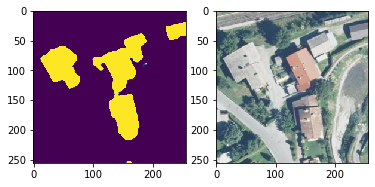

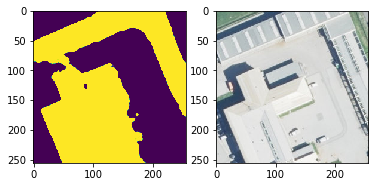

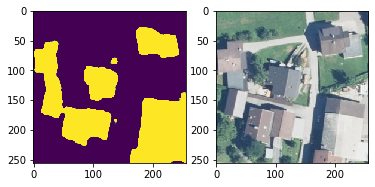

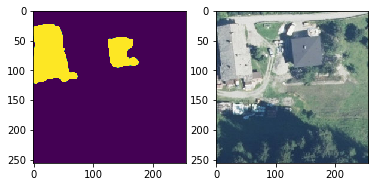

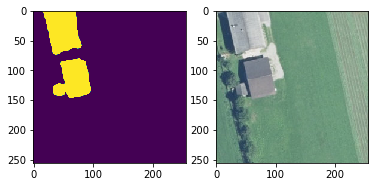

In [20]:
gen_iterator = iter(test_dataset)

for i in range(5):
    fig = plt.figure()
    
    pred_mask = prediction[i]
    test_img = next(gen_iterator)

    
    pred_mask = pred_mask[:,:,0]
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(pred_mask)
    

    test_img = test_img[0] 
    test_img = test_img / 255 
    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(test_img)
    

#### Encode prediction (run-length encoded)

In [21]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

      f.write('ImageId,EncodedPixels,Width,Height\n')

      for key, value in results.items():
          f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')

create_csv(res_dict, '')